In [7]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive
%cd MyDrive
%cd AE_Fault


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: 'drive'
/content/drive
/content/drive/MyDrive
/content/drive/MyDrive/AE_Fault


In [8]:
%ls

AE_Fault.ipynb  data.npy  feature_time_48k_2048_load_1.csv  labels.npy


In [9]:
import numpy as np
import gym
import matplotlib.pyplot as plt
import scipy.io as sc
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense, Reshape,  Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy

from sklearn.metrics import confusion_matrix, precision_score, recall_score

import os

In [10]:
data = np.load('data.npy')
label = np.load('labels.npy')
label_number = np.zeros(label.shape)

In [11]:
label_names = np.unique(label)

In [12]:
X = data.reshape([data.shape[0],-1])
Y = label_names.reshape([-1,1])

In [13]:
for i in range(len(label_names)):
    label_number[label == label_names[i]] = i

In [14]:
Y = label_number.reshape([-1,1])

In [15]:
MAX = X.max()
MIN = X.min()
X_NORMALIZED = (X - MIN) / (MAX - MIN)

In [16]:
# Convert integer labels to one-hot encoded labels
num_actions = len(np.unique(Y))
Y_one_hot = to_categorical(Y-1, num_classes=num_actions)

# Perform train-test split
X_train, X_test, Y_train, Y_test = train_test_split(X_NORMALIZED, Y_one_hot, test_size=0.2, random_state=42, shuffle=True)

# Print the shapes of the resulting sets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("Y_train shape:", Y_train.shape)
print("Y_test shape:", Y_test.shape)

X_train shape: (3680, 1024)
X_test shape: (920, 1024)
Y_train shape: (3680, 10)
Y_test shape: (920, 10)


In [17]:
normal_data_indices = np.where(Y_train == 0)[0]
X_train_normal = X_train[normal_data_indices]

normal_data_indices = np.where(Y_test == 0)[0]
X_test_normal = X_test[normal_data_indices]

In [18]:
input_img = Input(shape=(32, 32, 1))

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Flatten()(x)
encoded = Dense(32, activation='relu')(x)
x = Dense(8 * 8 * 8, activation='relu')(encoded)
x = Reshape((8, 8, 8))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

In [19]:
X_train_normal = X_train_normal.reshape([-1,32,32, 1])
X_test_normal = X_test_normal.reshape([-1,32,32, 1])

In [32]:
history2 = autoencoder.fit(X_train_normal, X_train_normal, epochs=20, batch_size=32, shuffle=True, validation_data=(X_test_normal, X_test_normal))

# Evaluate the performance
# conf_matrix = confusion_matrix(Y_test, y_pred)
# precision = precision_score(Y_test, y_pred, average='weighted')
# recall = recall_score(Y_test, y_pred, average='weighted')

# print("Confusion Matrix:\n", conf_matrix)
# print("Precision: {:.2f}".format(precision))
# print("Recall: {:.2f}".format(recall))

Epoch 1/20
1035/1035 [==============================] - 86s 83ms/step - loss: 2.6795e-04 - val_loss: 3.1859e-04
Epoch 2/20
1035/1035 [==============================] - 87s 84ms/step - loss: 2.6256e-04 - val_loss: 3.1688e-04
Epoch 3/20
1035/1035 [==============================] - 85s 82ms/step - loss: 2.5800e-04 - val_loss: 3.1463e-04
Epoch 4/20
1035/1035 [==============================] - 85s 82ms/step - loss: 2.5433e-04 - val_loss: 3.1564e-04
Epoch 5/20
1035/1035 [==============================] - 85s 82ms/step - loss: 2.5100e-04 - val_loss: 3.1229e-04
Epoch 6/20
1035/1035 [==============================] - 86s 83ms/step - loss: 2.4775e-04 - val_loss: 3.1304e-04
Epoch 7/20
1035/1035 [==============================] - 85s 82ms/step - loss: 2.4496e-04 - val_loss: 3.0757e-04
Epoch 8/20
1035/1035 [==============================] - 84s 81ms/step - loss: 2.4236e-04 - val_loss: 3.0707e-04
Epoch 9/20
1035/1035 [==============================] - 87s 84ms/step - loss: 2.3996e-04 - val_loss: 3.0

In [49]:
# Reconstruction and Thresholding
decoded_images = autoencoder.predict(X_test_normal)
mse = np.mean(np.square(X_test_normal - decoded_images), axis=(1, 2, 3))
threshold = np.mean(mse) - 0.1 * np.std(mse)

# Classify instances as normal or faulty based on the threshold
decoded_images_pred = autoencoder.predict(X_test.reshape([-1, 32, 32, 1]))
mse_pred = np.mean(np.square(X_test.reshape([-1,32,32, 1]) - decoded_images_pred), axis=(1, 2, 3))
y_pred = (mse_pred > threshold).astype(int)

29/29 [==============================] - 1s 48ms/step


In [50]:
# Evaluate the performance
temp = np.zeros(Y_test.shape[0])
temp[Y_test[:,0]==0] = 1

temp = temp.reshape([-1,1])
y_pred = y_pred.reshape([-1,1])
conf_matrix = confusion_matrix(temp, y_pred)
precision = precision_score(temp, y_pred, average='weighted')
recall = recall_score(temp, y_pred, average='weighted')

print("Confusion Matrix:\n", conf_matrix)
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))

Confusion Matrix:
 [[ 96   0]
 [487 337]]
Precision: 0.91
Recall: 0.47


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


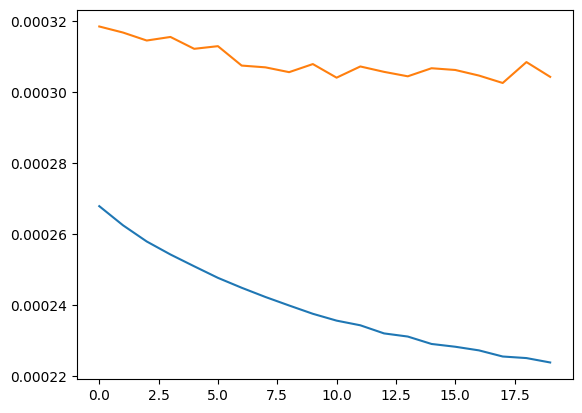

In [51]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])

<Axes: >

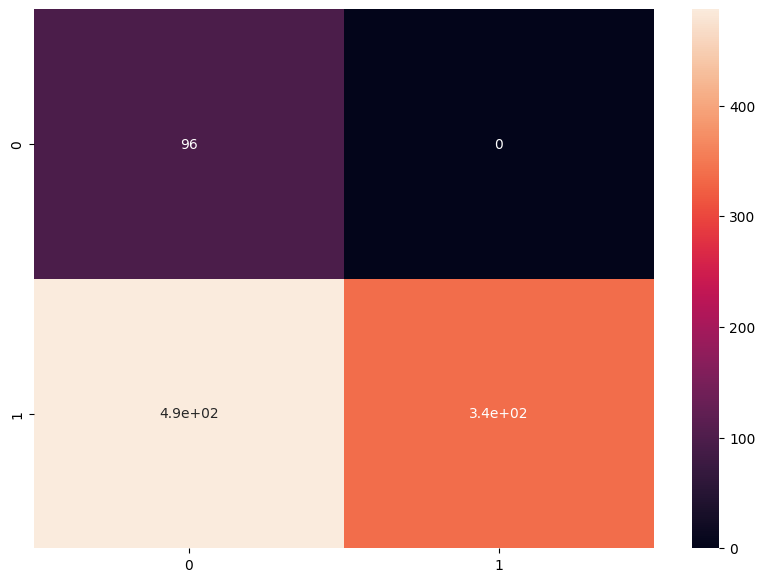

In [52]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize = (10,7))
sn.heatmap(conf_matrix, annot=True)